In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/el2358/.conda/envs/geoclim/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

In [3]:
wenchang_index = 1.113
muting_index = 1.243

obs_2020 = 23
obs_2005 = 20
obs_2009 = 7
obs_2002 = 8
obs_1982 = 2
obs_2010 = 15
obs_2013 = 10

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

def count_atlantic_storms(sn_file, years, na_lon_min=260, na_lon_max=357.5, na_lat_min=0, na_lat_max=40):
    """
    Count yearly North Atlantic storms from one storm track file using genesis location.
    """
    storms = []
    current_storm = []
    with open(sn_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("start"):
                if current_storm:
                    storms.append(current_storm)
                    current_storm = []
            else:
                parts = line.split()
                lon = float(parts[2])
                lat = float(parts[3])
                if lon < 0:
                    lon += 360
                current_storm.append((lon, lat))
        if current_storm:
            storms.append(current_storm)

    # Split storms evenly across years
    n_storms = len(storms) // len(years)
    yearly_counts = []
    for i, year in enumerate(years):
        storms_this_year = storms[i * n_storms:(i + 1) * n_storms]
        storms_na = []
        for storm in storms_this_year:
            lon_gen, lat_gen = storm[0]
            if (na_lon_min <= lon_gen <= na_lon_max) and (na_lat_min <= lat_gen <= na_lat_max):
                storms_na.append(storm)
        yearly_counts.append(len(storms_na))
    return np.array(yearly_counts)

# -------------------------------------------------------------------
# Main script
# -------------------------------------------------------------------

sn_dir = Path("/scratch/gpfs/GVECCHI/el2358/ACE2_1000/2020/tc_tracking/sn_txt")
years = np.arange(2020, 2121)

sn_files = sorted(sn_dir.glob("SN.ACE2.TC.*.txt"))

results = []  # will hold dicts with year, count, dataset

for sn_file in sn_files:
    dataset_tag = sn_file.stem.split(".")[-1]  # e.g., "1_100"
    counts = count_atlantic_storms(sn_file, years)
    for yr, cnt in zip(years, counts):
        results.append({"year": yr, "atlantic_tc_count": cnt, "dataset": dataset_tag})

# Convert to pandas DataFrame for easy analysis/saving
df = pd.DataFrame(results)
print(df.head())


   year  atlantic_tc_count  dataset
0  2020                 11  101_200
1  2021                 10  101_200
2  2022                 17  101_200
3  2023                 13  101_200
4  2024                  8  101_200


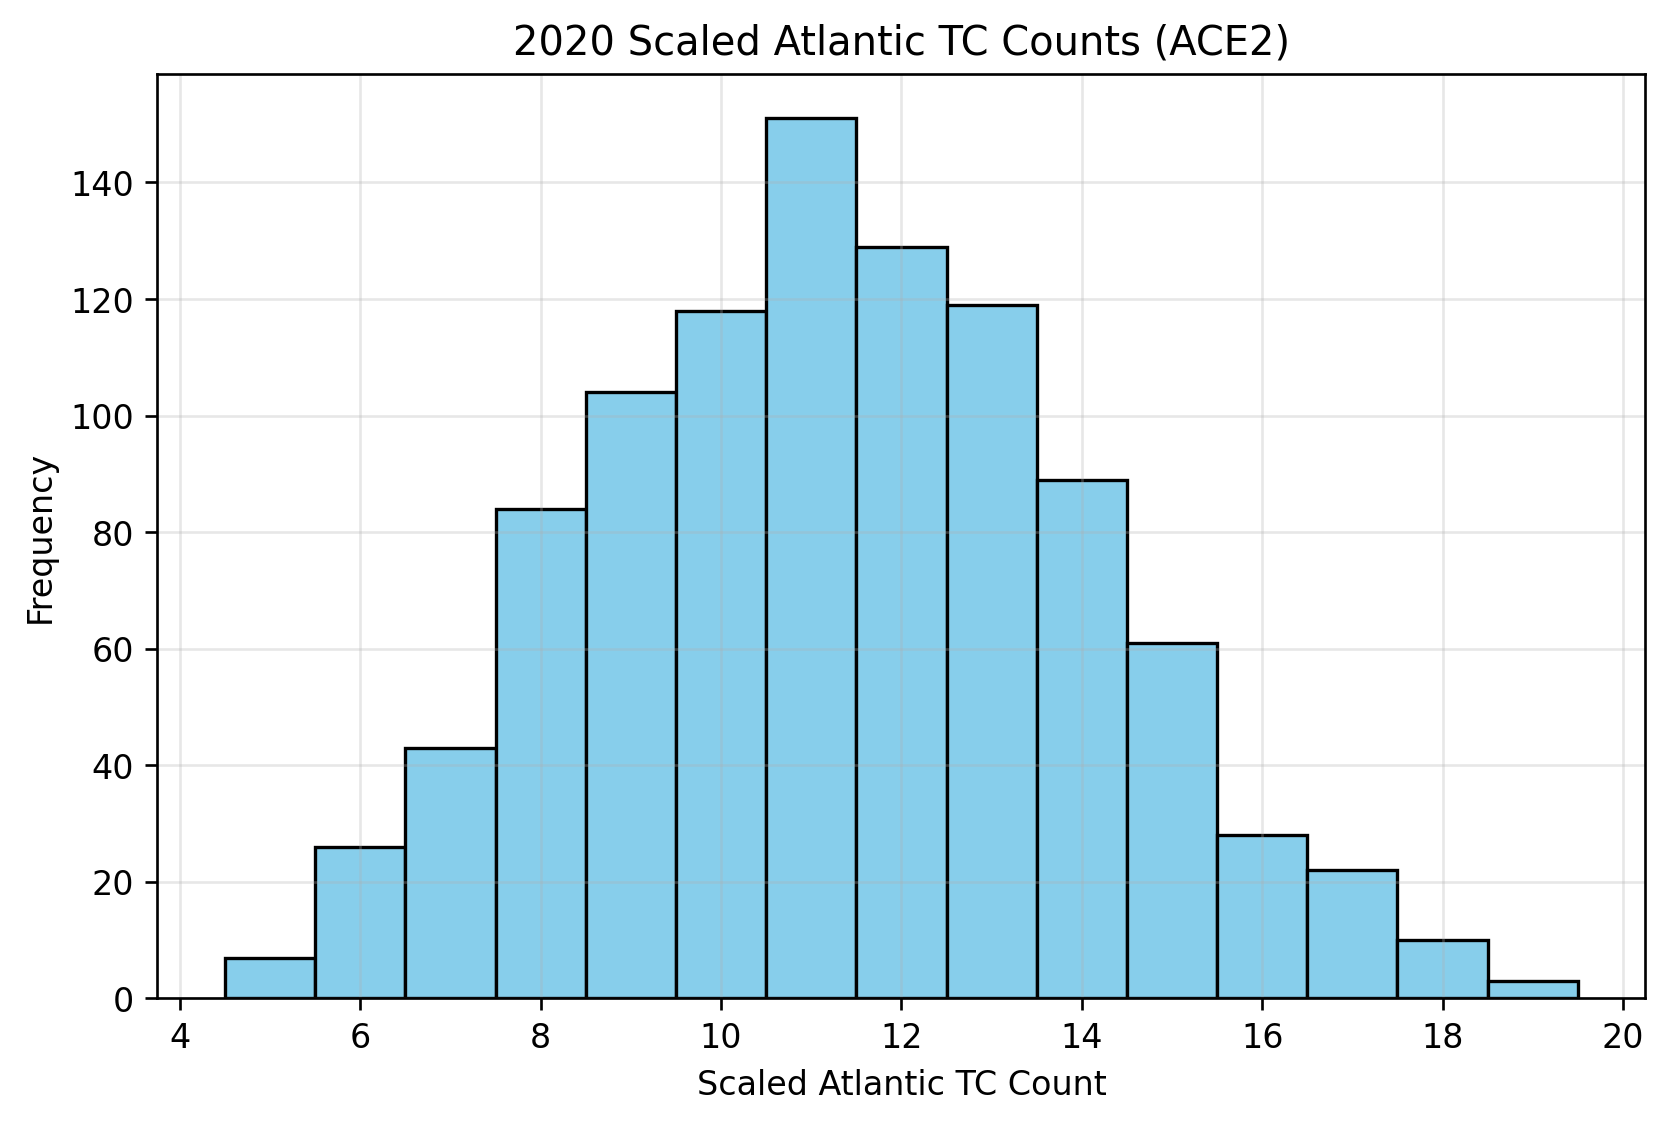

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Remove all 2120 data
df_filtered = df[df["year"] != 2120].copy()

# 3️⃣ Histogram setup
bins = np.arange(4.5, 20.5, 1.0)  # from -0.5 to 25.5 with 1-unit width

plt.figure(figsize=(8,5))
plt.hist(df_filtered["atlantic_tc_count"], bins=bins, color="skyblue", edgecolor="black")

plt.xlabel("Scaled Atlantic TC Count")
plt.ylabel("Frequency")
plt.title("2020 Scaled Atlantic TC Counts (ACE2)")
plt.grid(alpha=0.3)

plt.show()



In [6]:
df_filtered["atlantic_tc_count"].mean()

np.float64(11.312)

In [7]:
len(df_filtered)

1000

In [14]:
df_filtered['dataset'].unique()

array(['101_200', '1_100', '201_300', '301_400', '401_500', '501_600',
       '601_700', '701_800', '801_900', '901_1000'], dtype=object)

In [15]:
df_filtered.to_csv("/scratch/gpfs/GVECCHI/el2358/ACE2_1000/2020/tc_tracking/sn_txt/df_filtered.csv", index=False)

Data mean: 11.312
Data variance: 7.704
Dispersion ratio (var/mean): 0.681

Poisson: λ = 11.312
Binomial: n = 36, p = 0.319
Truncated Poisson: λ = 11.303 (truncated at 3)
Truncated Binomial: n = 36, p = 0.314
COM-Poisson: λ = 37.028, ν = 1.480
Generalized Poisson: θ = 13.722, λ = -0.213
Negative Binomial: r = 175.920, p = 0.939
Hermite: λ1 = 11.312, λ2 = 0.000


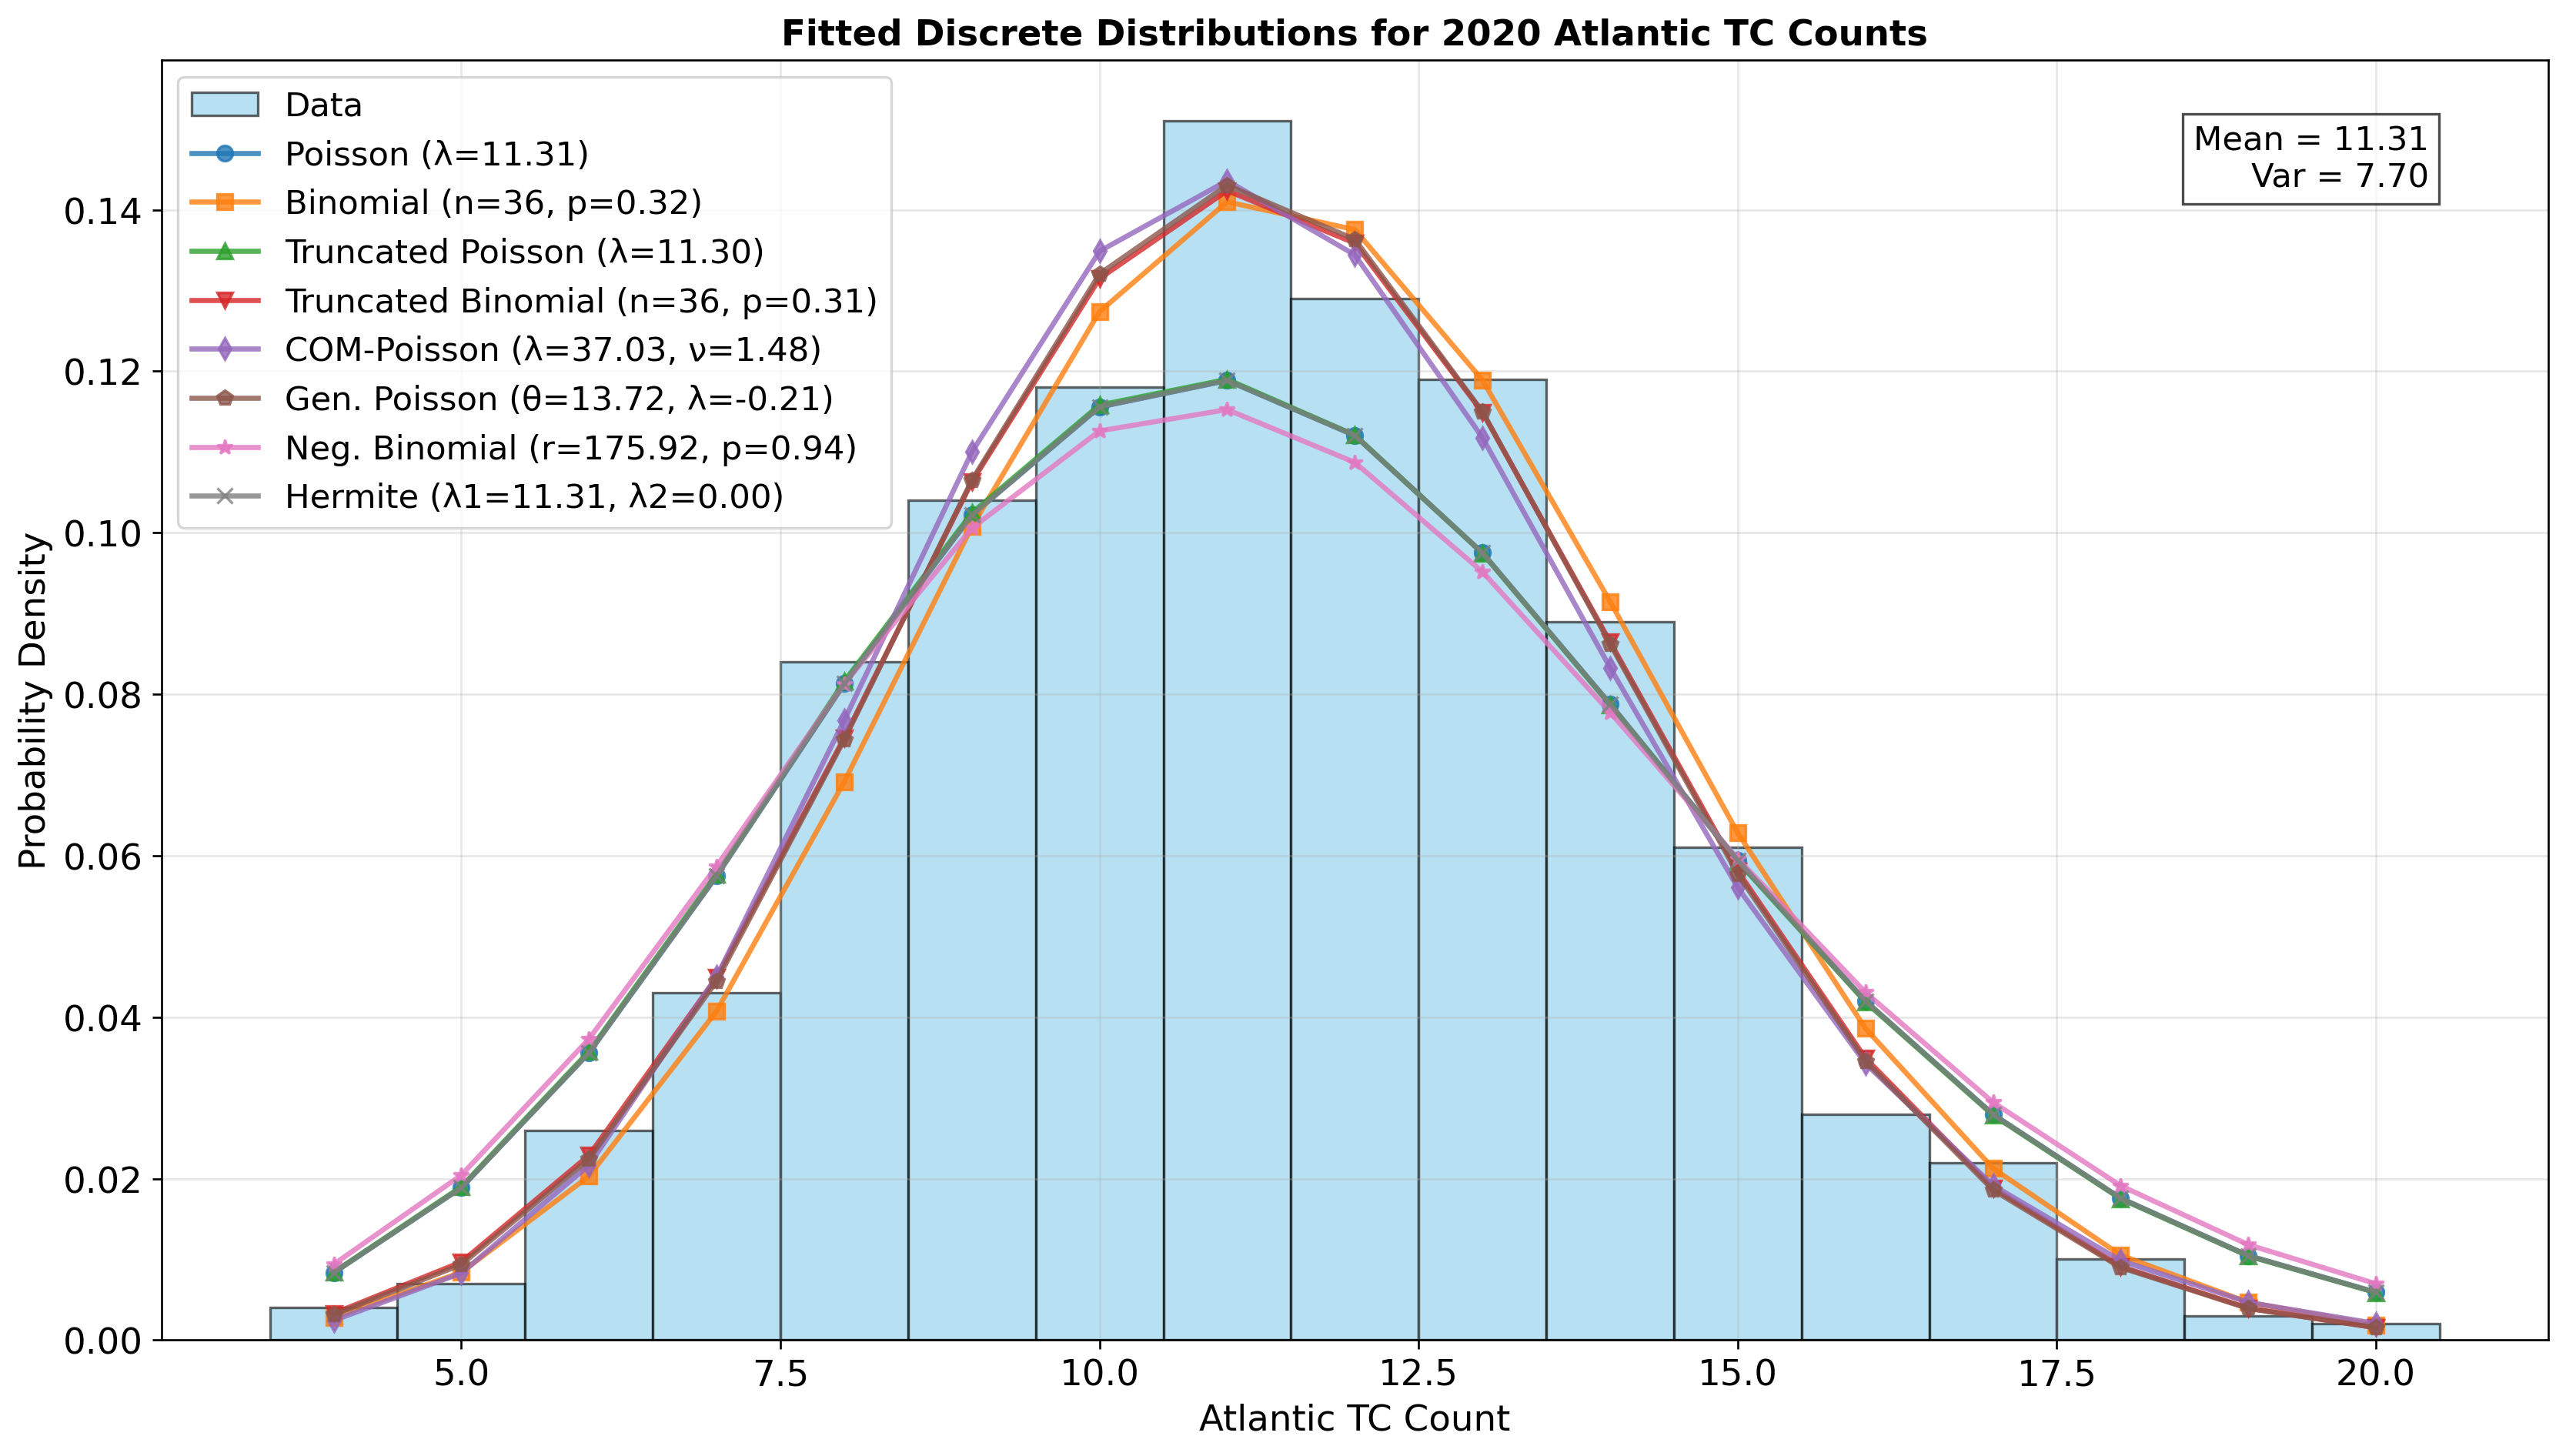


GOODNESS OF FIT (Chi-Square Tests)
Poisson                  : χ² =   50.597, dof = 15, p-value = 0.0000
Binomial                 : χ² =   10.386, dof = 12, p-value = 0.5822
Truncated Poisson        : χ² =   50.615, dof = 15, p-value = 0.0000
Truncated Binomial       : χ² =    6.702, dof = 12, p-value = 0.8766
COM-Poisson              : χ² =    7.998, dof = 12, p-value = 0.7853
Generalized Poisson      : χ² =    6.879, dof = 12, p-value = 0.8655
Negative Binomial        : χ² =   64.123, dof = 14, p-value = 0.0000
Hermite                  : χ² =   50.597, dof = 14, p-value = 0.0000


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.special import factorial, gammaln
import warnings
warnings.filterwarnings('ignore')

# Assuming df_filtered is already defined
# df_filtered = df[df["year"] != 2120].copy()

data = df_filtered['atlantic_tc_count'].values
n_data = len(data)

# Calculate basic statistics
data_mean = np.mean(data)
data_var = np.var(data, ddof=1)
print(f"Data mean: {data_mean:.3f}")
print(f"Data variance: {data_var:.3f}")
print(f"Dispersion ratio (var/mean): {data_var/data_mean:.3f}")
print()

# ============================================
# 1. POISSON DISTRIBUTION
# ============================================
lambda_mle = data_mean
poisson_pmf = stats.poisson.pmf(range(int(data.max())+1), lambda_mle)
print(f"Poisson: λ = {lambda_mle:.3f}")

# ============================================
# 2. BINOMIAL DISTRIBUTION
# ============================================
def fit_binomial(data):
    mean_data = np.mean(data)
    var_data = np.var(data, ddof=1)
    
    # Use method of moments
    p_est = 1 - var_data / mean_data
    n_est = mean_data / p_est
    
    # Ensure valid parameters
    p_est = np.clip(p_est, 0.01, 0.99)
    n_est = max(int(np.ceil(n_est)), int(data.max()) + 1)
    
    return n_est, p_est

n_binom, p_binom = fit_binomial(data)
binomial_pmf = stats.binom.pmf(range(int(data.max())+1), n_binom, p_binom)
print(f"Binomial: n = {n_binom}, p = {p_binom:.3f}")

# ============================================
# 3. TRUNCATED POISSON (left-truncated at 0)
# ============================================
def truncated_poisson_pmf(k, lam, lower=0):
    """PMF for left-truncated Poisson"""
    if lower == 0:
        cdf_lower = 0
    else:
        cdf_lower = stats.poisson.cdf(lower - 1, lam)
    
    pmf = stats.poisson.pmf(k, lam) / (1 - cdf_lower)
    pmf[k <= lower] = 0
    return pmf

def truncated_poisson_nll(lam, data, lower=0):
    """Negative log-likelihood for truncated Poisson"""
    if lam <= 0:
        return 1e10
    
    if lower == 0:
        cdf_lower = 0
    else:
        cdf_lower = stats.poisson.cdf(lower - 1, lam)
    
    ll = np.sum(stats.poisson.logpmf(data, lam)) - n_data * np.log(1 - cdf_lower)
    return -ll

# Fit truncated Poisson (truncated at lower bound of data)
lower_trunc = int(data.min()) - 1
res_tpoisson = minimize(lambda x: truncated_poisson_nll(x[0], data, lower_trunc), 
                        [data_mean], method='L-BFGS-B', bounds=[(0.1, 100)])
lambda_tpoisson = res_tpoisson.x[0]
k_vals = np.arange(int(data.max())+1)
tpoisson_pmf = truncated_poisson_pmf(k_vals, lambda_tpoisson, lower_trunc)
print(f"Truncated Poisson: λ = {lambda_tpoisson:.3f} (truncated at {lower_trunc})")

# ============================================
# 4. TRUNCATED BINOMIAL
# ============================================
def truncated_binomial_nll(params, data, lower=0):
    """Negative log-likelihood for truncated binomial"""
    n, p = int(params[0]), params[1]
    if p <= 0 or p >= 1 or n < data.max():
        return 1e10
    
    if lower == 0:
        cdf_lower = 0
    else:
        cdf_lower = stats.binom.cdf(lower - 1, n, p)
    
    ll = np.sum(stats.binom.logpmf(data, n, p)) - n_data * np.log(1 - cdf_lower)
    return -ll

res_tbinom = minimize(lambda x: truncated_binomial_nll(x, data, lower_trunc),
                      [n_binom, p_binom], method='L-BFGS-B', 
                      bounds=[(data.max()+1, 100), (0.01, 0.99)])
n_tbinom, p_tbinom = int(res_tbinom.x[0]), res_tbinom.x[1]
tbinom_pmf = stats.binom.pmf(k_vals, n_tbinom, p_tbinom)
tbinom_pmf[k_vals <= lower_trunc] = 0
tbinom_pmf = tbinom_pmf / (1 - stats.binom.cdf(lower_trunc, n_tbinom, p_tbinom))
print(f"Truncated Binomial: n = {n_tbinom}, p = {p_tbinom:.3f}")

# ============================================
# 5. CONWAY-MAXWELL-POISSON (COM-Poisson)
# ============================================
def com_poisson_logZ(lam, nu, max_k=100):
    """Log normalizing constant for COM-Poisson"""
    k_vals = np.arange(max_k)
    log_terms = k_vals * np.log(lam) - nu * gammaln(k_vals + 1)
    max_log = np.max(log_terms)
    return max_log + np.log(np.sum(np.exp(log_terms - max_log)))

def com_poisson_nll(params, data):
    """Negative log-likelihood for COM-Poisson"""
    lam, nu = params
    if lam <= 0 or nu <= 0:
        return 1e10
    
    logZ = com_poisson_logZ(lam, nu)
    ll = np.sum(data * np.log(lam) - nu * gammaln(data + 1)) - n_data * logZ
    return -ll

res_comp = minimize(lambda x: com_poisson_nll(x, data), 
                    [data_mean, 1.0], method='L-BFGS-B',
                    bounds=[(0.1, 100), (0.1, 10)])
lam_comp, nu_comp = res_comp.x
print(f"COM-Poisson: λ = {lam_comp:.3f}, ν = {nu_comp:.3f}")

# Calculate COM-Poisson PMF
logZ_comp = com_poisson_logZ(lam_comp, nu_comp)
comp_pmf = np.exp(k_vals * np.log(lam_comp) - nu_comp * gammaln(k_vals + 1) - logZ_comp)

# ============================================
# 6. GENERALIZED POISSON
# ============================================
def gen_poisson_pmf(k, theta, lam):
    """PMF for Generalized Poisson Distribution"""
    if lam >= 1 or lam <= -1:
        return np.zeros_like(k, dtype=float)
    
    term1 = theta * (theta + lam * k)**(k - 1)
    term2 = np.exp(-theta - lam * k)
    term3 = 1 / factorial(k)
    
    return term1 * term2 * term3

def gen_poisson_nll(params, data):
    """Negative log-likelihood for Generalized Poisson"""
    theta, lam = params
    if theta <= 0 or lam >= 1 or lam <= -1:
        return 1e10
    
    # Avoid numerical issues
    try:
        ll = np.sum(np.log(theta) + (data - 1) * np.log(theta + lam * data) 
                    - theta - lam * data - gammaln(data + 1))
        if np.isnan(ll) or np.isinf(ll):
            return 1e10
        return -ll
    except:
        return 1e10

# Initial guess for Generalized Poisson
theta_init = data_mean * (1 - (data_var - data_mean) / data_mean**2)
lam_init = (data_var - data_mean) / data_mean**2
lam_init = np.clip(lam_init, -0.9, 0.9)

res_gp = minimize(lambda x: gen_poisson_nll(x, data),
                  [theta_init, lam_init], method='L-BFGS-B',
                  bounds=[(0.1, 100), (-0.99, 0.99)])
theta_gp, lam_gp = res_gp.x
gp_pmf = gen_poisson_pmf(k_vals, theta_gp, lam_gp)
print(f"Generalized Poisson: θ = {theta_gp:.3f}, λ = {lam_gp:.3f}")

# ============================================
# 7. NEGATIVE BINOMIAL
# ============================================
def nbinom_nll(params, data):
    r, p = params
    if r <= 0 or p <= 0 or p >= 1:
        return 1e10
    ll = np.sum(stats.nbinom.logpmf(data, r, p))
    return -ll

# Initial guess
r_init = data_mean**2 / (data_var - data_mean) if data_var > data_mean else 10
p_init = r_init / (r_init + data_mean)

res_nb = minimize(lambda x: nbinom_nll(x, data),
                  [r_init, p_init], method='L-BFGS-B',
                  bounds=[(1e-6, 500), (1e-6, 0.999999)])

r_nb, p_nb = res_nb.x
nb_pmf = stats.nbinom.pmf(k_vals, r_nb, p_nb)
print(f"Negative Binomial: r = {r_nb:.3f}, p = {p_nb:.3f}")


# ============================================
# 8. HERMITE DISTRIBUTION
# ============================================
def hermite_pmf(k, lam1, lam2):
    pmf = np.zeros_like(k, dtype=float)
    for idx, ki in enumerate(k):
        m_vals = np.arange(0, ki//2 + 1)
        terms = (lam1**(ki - 2*m_vals) / factorial(ki - 2*m_vals)) * \
                (lam2**m_vals / factorial(m_vals))
        pmf[idx] = np.exp(-(lam1 + lam2)) * np.sum(terms)
    return pmf

def hermite_nll(params, data):
    lam1, lam2 = params
    if lam1 <= 0 or lam2 < 0:  # lam2 can be zero
        return 1e10
    pmf_vals = hermite_pmf(data, lam1, lam2)
    if np.any(pmf_vals <= 0):
        return 1e10
    return -np.sum(np.log(pmf_vals))

res_herm = minimize(lambda x: hermite_nll(x, data),
                    [data_mean, (data_mean**2-data_var)/2 if data_mean**2>data_var else 0.1],
                    method='L-BFGS-B',
                    bounds=[(1e-6, 200), (0, 200)])

lam1_herm, lam2_herm = res_herm.x
herm_pmf = hermite_pmf(k_vals, lam1_herm, lam2_herm)
print(f"Hermite: λ1 = {lam1_herm:.3f}, λ2 = {lam2_herm:.3f}")


# ============================================
# PLOTTING
# ============================================
bins = np.arange(data.min() - 0.5, data.max() + 1.5, 1.0)

plt.figure(figsize=(14, 8))

# Plot histogram
counts, bins, patches = plt.hist(data, bins=bins, density=True, alpha=0.6, 
                                  color='skyblue', edgecolor='black', label='Data')

# Plot fitted distributions
x_plot = np.arange(int(data.min()), int(data.max()) + 1)

plt.plot(x_plot, poisson_pmf[x_plot], 'o-', linewidth=2, markersize=6, 
         label=f'Poisson (λ={lambda_mle:.2f})', alpha=0.8)
plt.plot(x_plot, binomial_pmf[x_plot], 's-', linewidth=2, markersize=6,
         label=f'Binomial (n={n_binom}, p={p_binom:.2f})', alpha=0.8)
plt.plot(x_plot, tpoisson_pmf[x_plot], '^-', linewidth=2, markersize=6,
         label=f'Truncated Poisson (λ={lambda_tpoisson:.2f})', alpha=0.8)
plt.plot(x_plot, tbinom_pmf[x_plot], 'v-', linewidth=2, markersize=6,
         label=f'Truncated Binomial (n={n_tbinom}, p={p_tbinom:.2f})', alpha=0.8)
plt.plot(x_plot, comp_pmf[x_plot], 'd-', linewidth=2, markersize=6,
         label=f'COM-Poisson (λ={lam_comp:.2f}, ν={nu_comp:.2f})', alpha=0.8)
plt.plot(x_plot, gp_pmf[x_plot], 'p-', linewidth=2, markersize=6,
         label=f'Gen. Poisson (θ={theta_gp:.2f}, λ={lam_gp:.2f})', alpha=0.8)
plt.plot(x_plot, nb_pmf[x_plot], '*-', linewidth=2, markersize=6,
         label=f'Neg. Binomial (r={r_nb:.2f}, p={p_nb:.2f})', alpha=0.8)
plt.plot(x_plot, herm_pmf[x_plot], 'x-', linewidth=2, markersize=6,
         label=f'Hermite (λ1={lam1_herm:.2f}, λ2={lam2_herm:.2f})', alpha=0.8)

# Compute mean and variance
mean_val = np.mean(data)
var_val = np.var(data)

# Add text box
plt.text(0.95, 0.95, f'Mean = {mean_val:.2f}\nVar = {var_val:.2f}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=13, 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.xlabel('Atlantic TC Count', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Fitted Discrete Distributions for 2020 Atlantic TC Counts', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================
# GOODNESS OF FIT - Chi-Square Test
# ============================================
print("\n" + "="*60)
print("GOODNESS OF FIT (Chi-Square Tests)")
print("="*60)

def chi_square_test_robust(name, observed_counts, expected_pmf, x_vals, min_expected=5):
    """
    Chi-square goodness-of-fit test with intelligent bin pooling.
    
    Parameters:
    -----------
    name : str
        Name of the distribution (for reporting)
    observed_counts : array-like
        Observed frequencies in each bin
    expected_pmf : array-like
        Expected probabilities for each value
    x_vals : array-like
        The x-values corresponding to each bin
    min_expected : float
        Minimum expected count per bin (default 5)
    
    Returns:
    --------
    chi2 : float or None
        Chi-square statistic
    dof : int or None
        Degrees of freedom
    p_value : float or None
        p-value for the test
    """
    n_data = np.sum(observed_counts)
    expected_counts = expected_pmf[x_vals] * n_data
    
    # Convert to lists for easier manipulation
    obs = list(observed_counts.copy())
    exp = list(expected_counts.copy())
    
    # Pool adjacent bins until all expected counts >= min_expected
    i = 0
    while i < len(exp):
        if exp[i] < min_expected:
            # Try to pool with next bin
            if i + 1 < len(exp):
                obs[i] += obs[i + 1]
                exp[i] += exp[i + 1]
                obs.pop(i + 1)
                exp.pop(i + 1)
                # Don't increment i, check this bin again
            # Try to pool with previous bin
            elif i > 0:
                obs[i - 1] += obs[i]
                exp[i - 1] += exp[i]
                obs.pop(i)
                exp.pop(i)
                i -= 1  # Go back to check the merged bin
            else:
                # Only one bin left and it's < min_expected
                return None, None, None
        else:
            i += 1
    
    # Need at least 3 bins for a meaningful test
    if len(exp) < 3:
        return None, None, None
    
    # Convert back to numpy arrays
    obs = np.array(obs)
    exp = np.array(exp)
    
    # Calculate chi-square statistic
    chi2 = np.sum((obs - exp)**2 / exp)
    
    # Parameter counts for DOF adjustment
    param_counts = {
        'Poisson': 1,
        'Binomial': 2,
        'Truncated Poisson': 1,
        'Truncated Binomial': 2,
        'COM-Poisson': 2,
        'Generalized Poisson': 2,
        'Negative Binomial': 2,
        'Hermite': 2,
    }
    
    n_params = param_counts.get(name, 2)  # Default to 2 if not found
    
    # Degrees of freedom
    dof = len(exp) - 1 - n_params
    
    if dof < 1:
        return None, None, None
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(chi2, dof)
    
    return chi2, dof, p_value


# Get observed counts
observed, _ = np.histogram(data, bins=bins)
x_vals = np.arange(int(data.min()), int(data.max()) + 1)

distributions = {
    'Poisson': poisson_pmf,
    'Binomial': binomial_pmf,
    'Truncated Poisson': tpoisson_pmf,
    'Truncated Binomial': tbinom_pmf,
    'COM-Poisson': comp_pmf,
    'Generalized Poisson': gp_pmf,
    'Negative Binomial': nb_pmf,
    'Hermite': herm_pmf
}

for name, pmf in distributions.items():
    chi2, dof, p_val = chi_square_test_robust(name, observed, pmf, x_vals)
    if chi2 is not None:
        print(f"{name:25s}: χ² = {chi2:8.3f}, dof = {dof:2d}, p-value = {p_val:.4f}")
    else:
        print(f"{name:25s}: Unable to compute (insufficient data)")


GENERATING Q-Q PLOTS


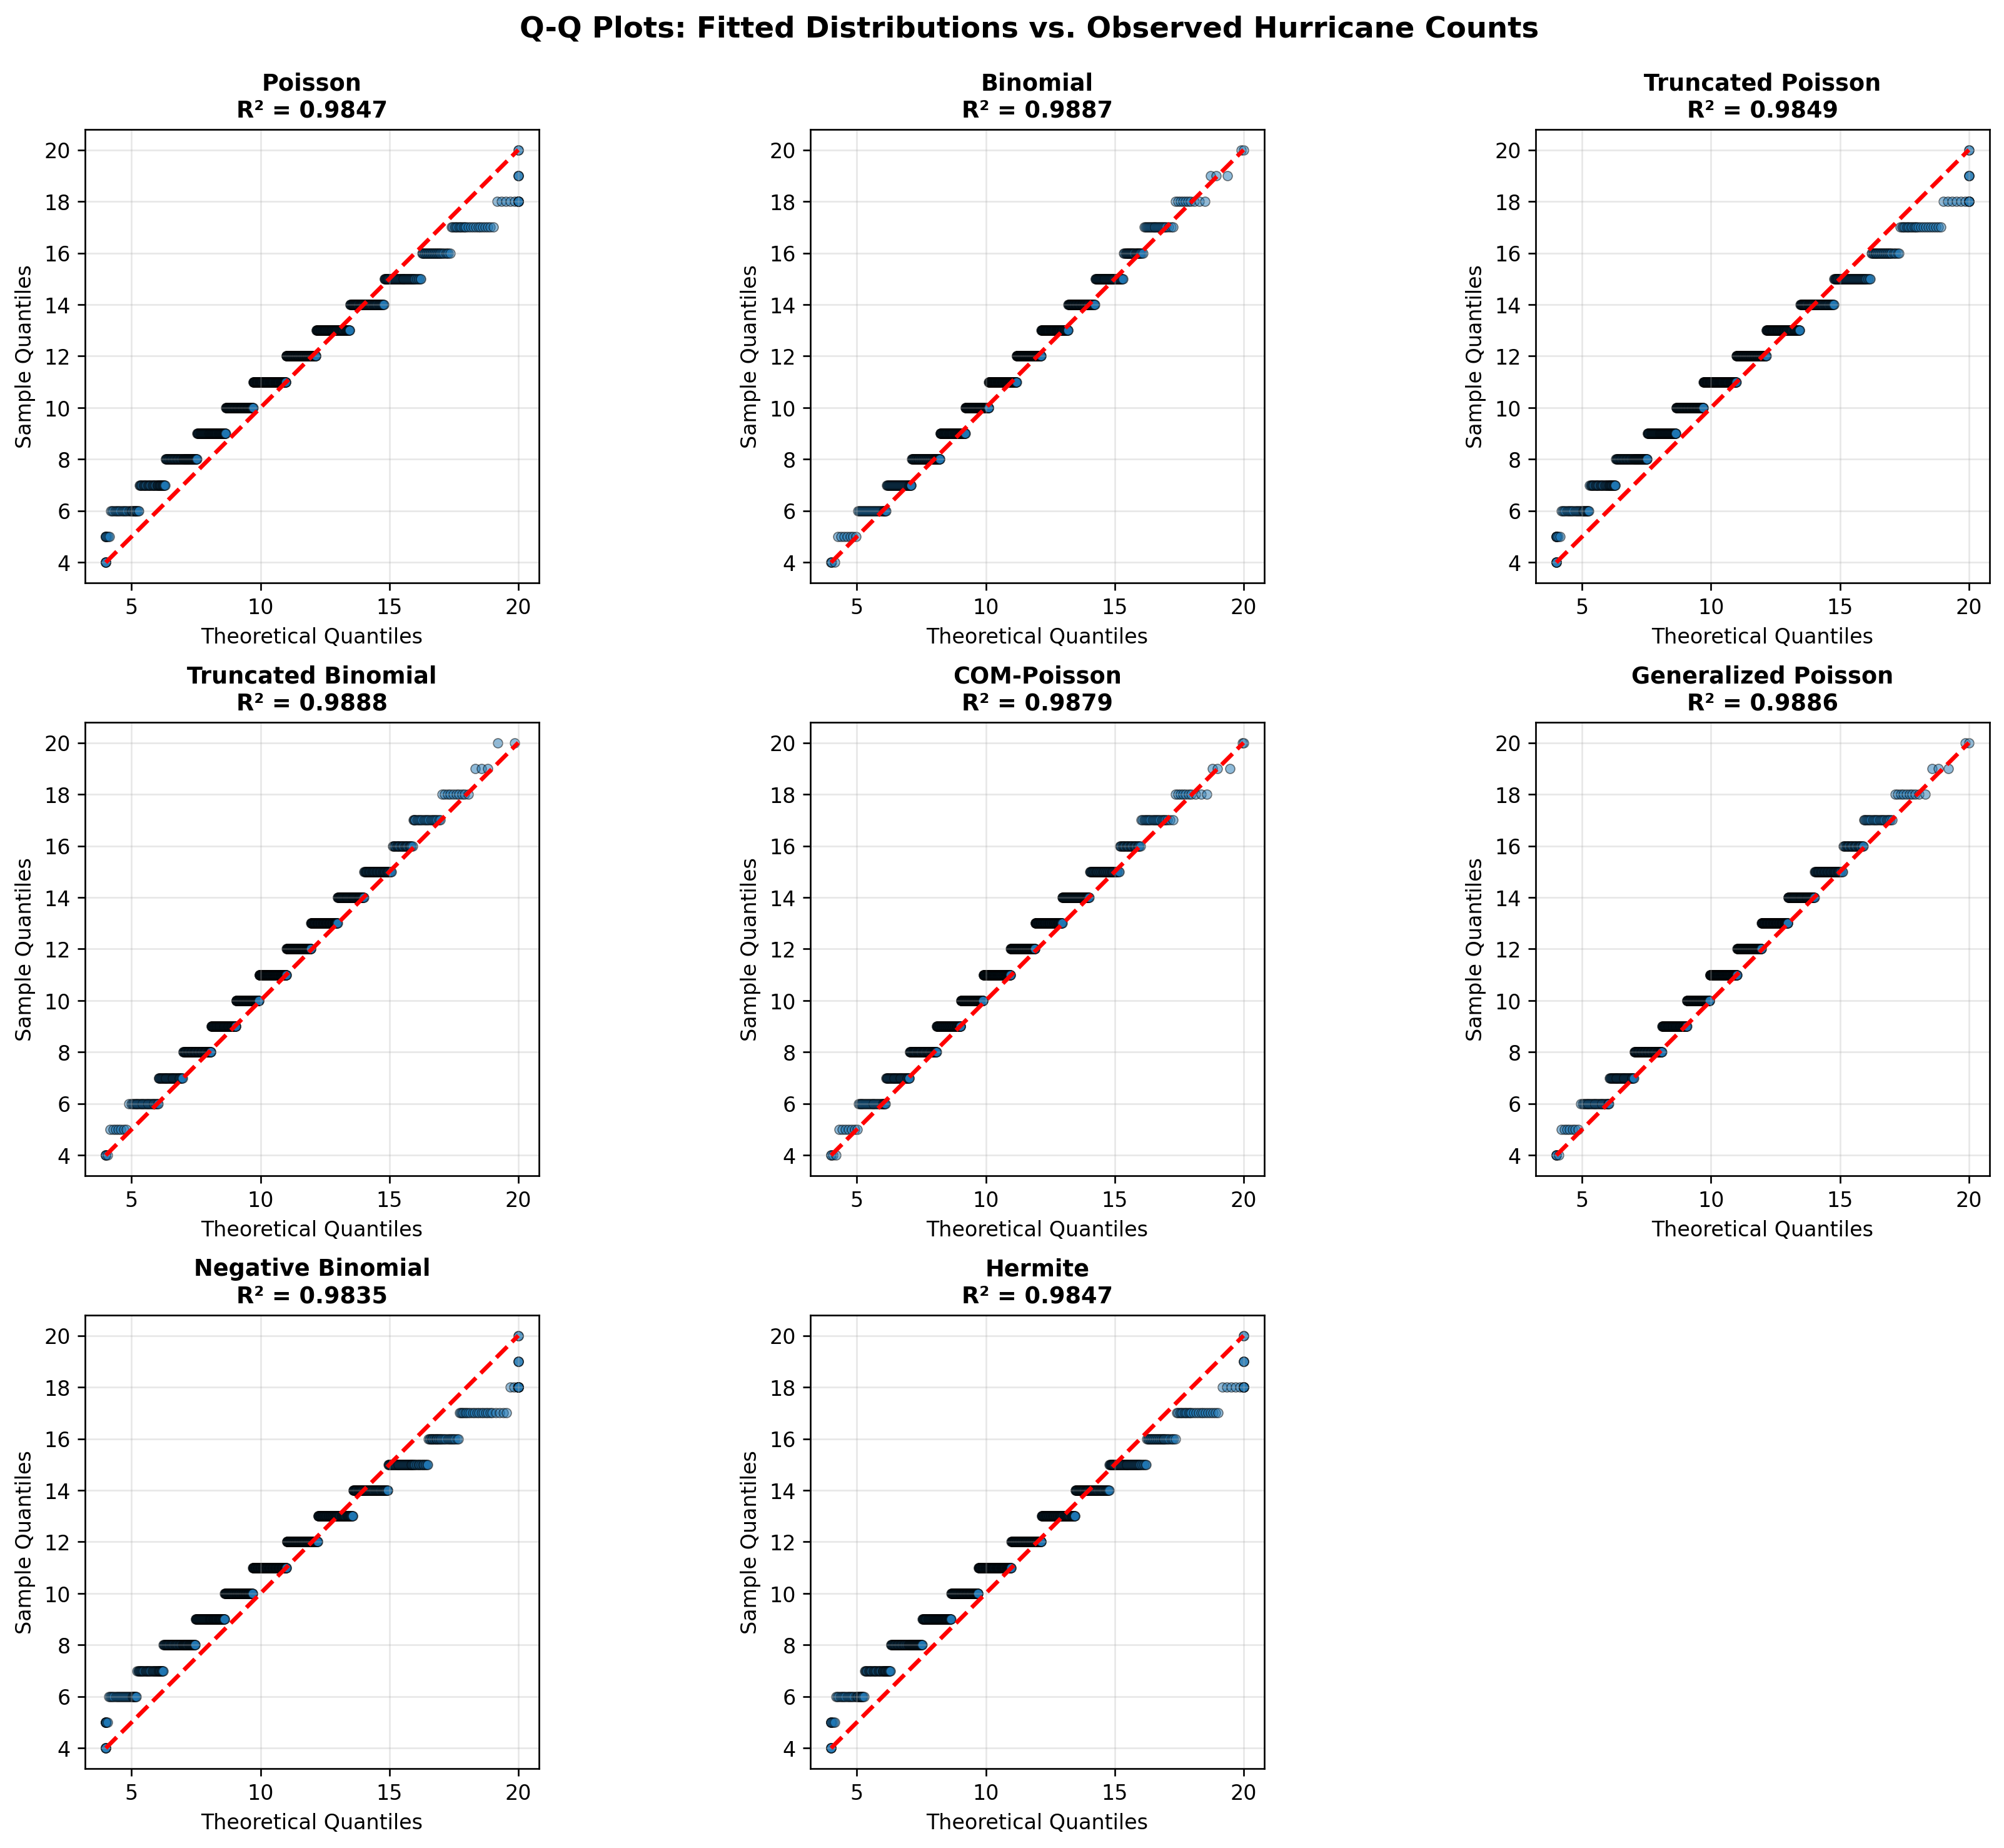


Q-Q Plot R² values (closer to 1 is better):
------------------------------------------------------------
Poisson                  : R² = 0.9847
Binomial                 : R² = 0.9887
Truncated Poisson        : R² = 0.9849
Truncated Binomial       : R² = 0.9888
COM-Poisson              : R² = 0.9879
Generalized Poisson      : R² = 0.9886
Negative Binomial        : R² = 0.9835
Hermite                  : R² = 0.9847


In [13]:
# ============================================
# Q-Q PLOTS
# ============================================
print("\n" + "="*60)
print("GENERATING Q-Q PLOTS")
print("="*60)

def generate_theoretical_quantiles(pmf, x_vals, n_samples):
    """Generate theoretical quantiles from a PMF"""
    cdf = np.cumsum(pmf[x_vals])
    quantiles = np.linspace(0, 1, n_samples + 2)[1:-1]
    theoretical = np.interp(quantiles, cdf, x_vals)
    return theoretical

# Sort observed data
data_sorted = np.sort(data)

# ✅ Include NB + Hermite
distributions_list = [
    ('Poisson', poisson_pmf, f'λ={lambda_mle:.2f}'),
    ('Binomial', binomial_pmf, f'n={n_binom}, p={p_binom:.2f}'),
    ('Truncated Poisson', tpoisson_pmf, f'λ={lambda_tpoisson:.2f}'),
    ('Truncated Binomial', tbinom_pmf, f'n={n_tbinom}, p={p_tbinom:.2f}'),
    ('COM-Poisson', comp_pmf, f'λ={lam_comp:.2f}, ν={nu_comp:.2f}'),
    ('Generalized Poisson', gp_pmf, f'θ={theta_gp:.2f}, λ={lam_gp:.2f}'),
    ('Negative Binomial', nb_pmf, f'r={r_nb:.2f}, p={p_nb:.2f}'),
    ('Hermite', herm_pmf, f'λ1={lam1_herm:.2f}, λ2={lam2_herm:.2f}')
]

# ✅ Update layout to 3×3 to fit 8 plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, pmf, params) in enumerate(distributions_list):
    ax = axes[idx]
    
    theoretical = generate_theoretical_quantiles(pmf, x_vals, n_data)

    ax.scatter(theoretical, data_sorted, alpha=0.5, s=20, edgecolors='black', linewidths=0.5)

    min_val = min(theoretical.min(), data_sorted.min())
    max_val = max(theoretical.max(), data_sorted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    correlation = np.corrcoef(theoretical, data_sorted)[0, 1]
    r_squared = correlation ** 2
    
    ax.set_title(f'{name}\nR² = {r_squared:.4f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.grid(alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Remove extra subplot if present
for j in range(len(distributions_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Q-Q Plots: Fitted Distributions vs. Observed Hurricane Counts', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print R² table
print("\nQ-Q Plot R² values (closer to 1 is better):")
print("-" * 60)
for name, pmf, params in distributions_list:
    theoretical = generate_theoretical_quantiles(pmf, x_vals, n_data)
    r2 = np.corrcoef(theoretical, data_sorted)[0, 1] ** 2
    print(f"{name:25s}: R² = {r2:.4f}")


# 1990 controls 

In [3]:
hiram = xr.open_dataset('/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/netcdf/tc_counts.TS17.0101-0300.yearly.nc').NA
am = xr.open_dataset('/tigress/wenchang/analysis/TC/AM2.5C360/CTL1990s_tigercpu_intelmpi_18_1080PE/netcdf/tc_counts.TS17.0101-0200.yearly.nc').NA


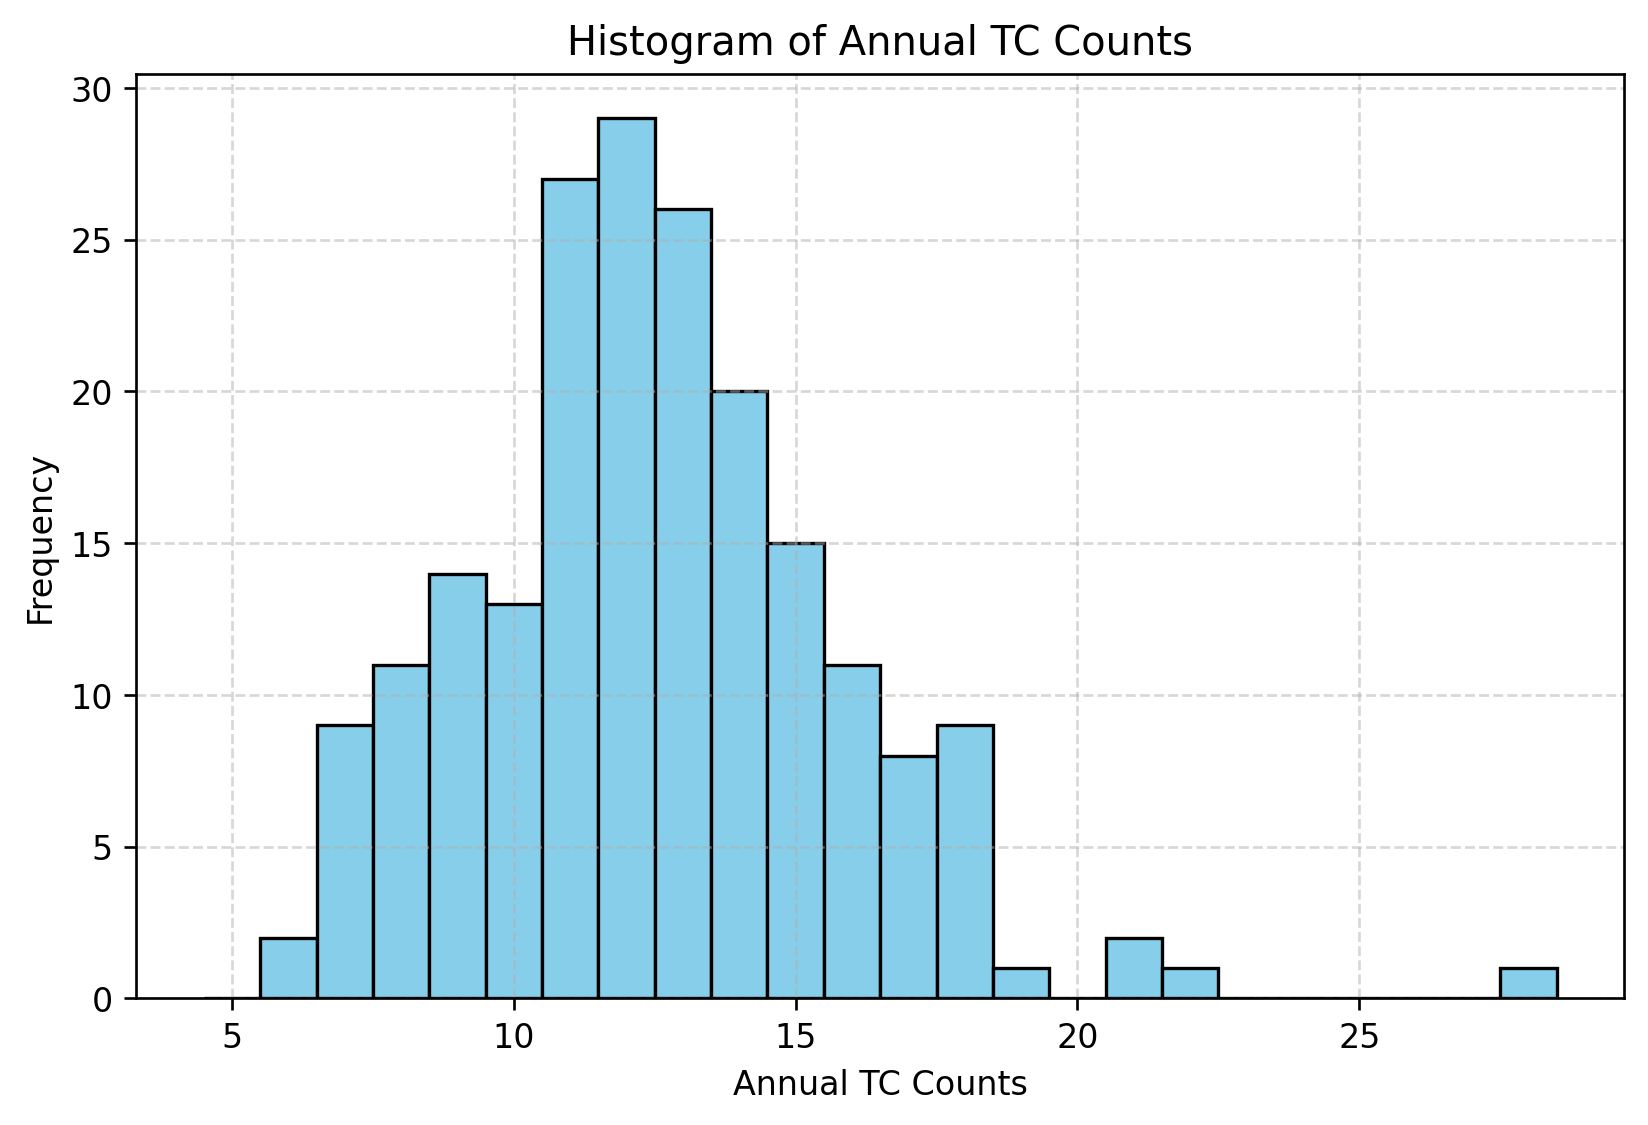

In [4]:
import matplotlib.pyplot as plt

# Assuming hiram is a 1D xarray DataArray with dim 'year'
data = hiram.values  # convert to numpy array for plotting

plt.figure(figsize=(8,5))
bins = np.arange(4.5, 29.5, 1.0)  # from -0.5 to 25.5 with 1-unit width
plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Annual TC Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Annual TC Counts')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [40]:

# Basic statistics
data_mean = np.mean(data)
data_var = np.var(data, ddof=1)
print(f"Data mean: {data_mean:.3f}")
print(f"Data variance: {data_var:.3f}")
print(f"Dispersion ratio (var/mean): {data_var/data_mean:.3f}\n")

Data mean: 7.040
Data variance: 3.835
Dispersion ratio (var/mean): 0.545



Data mean: 12.480
Data variance: 11.075
Dispersion ratio (var/mean): 0.887



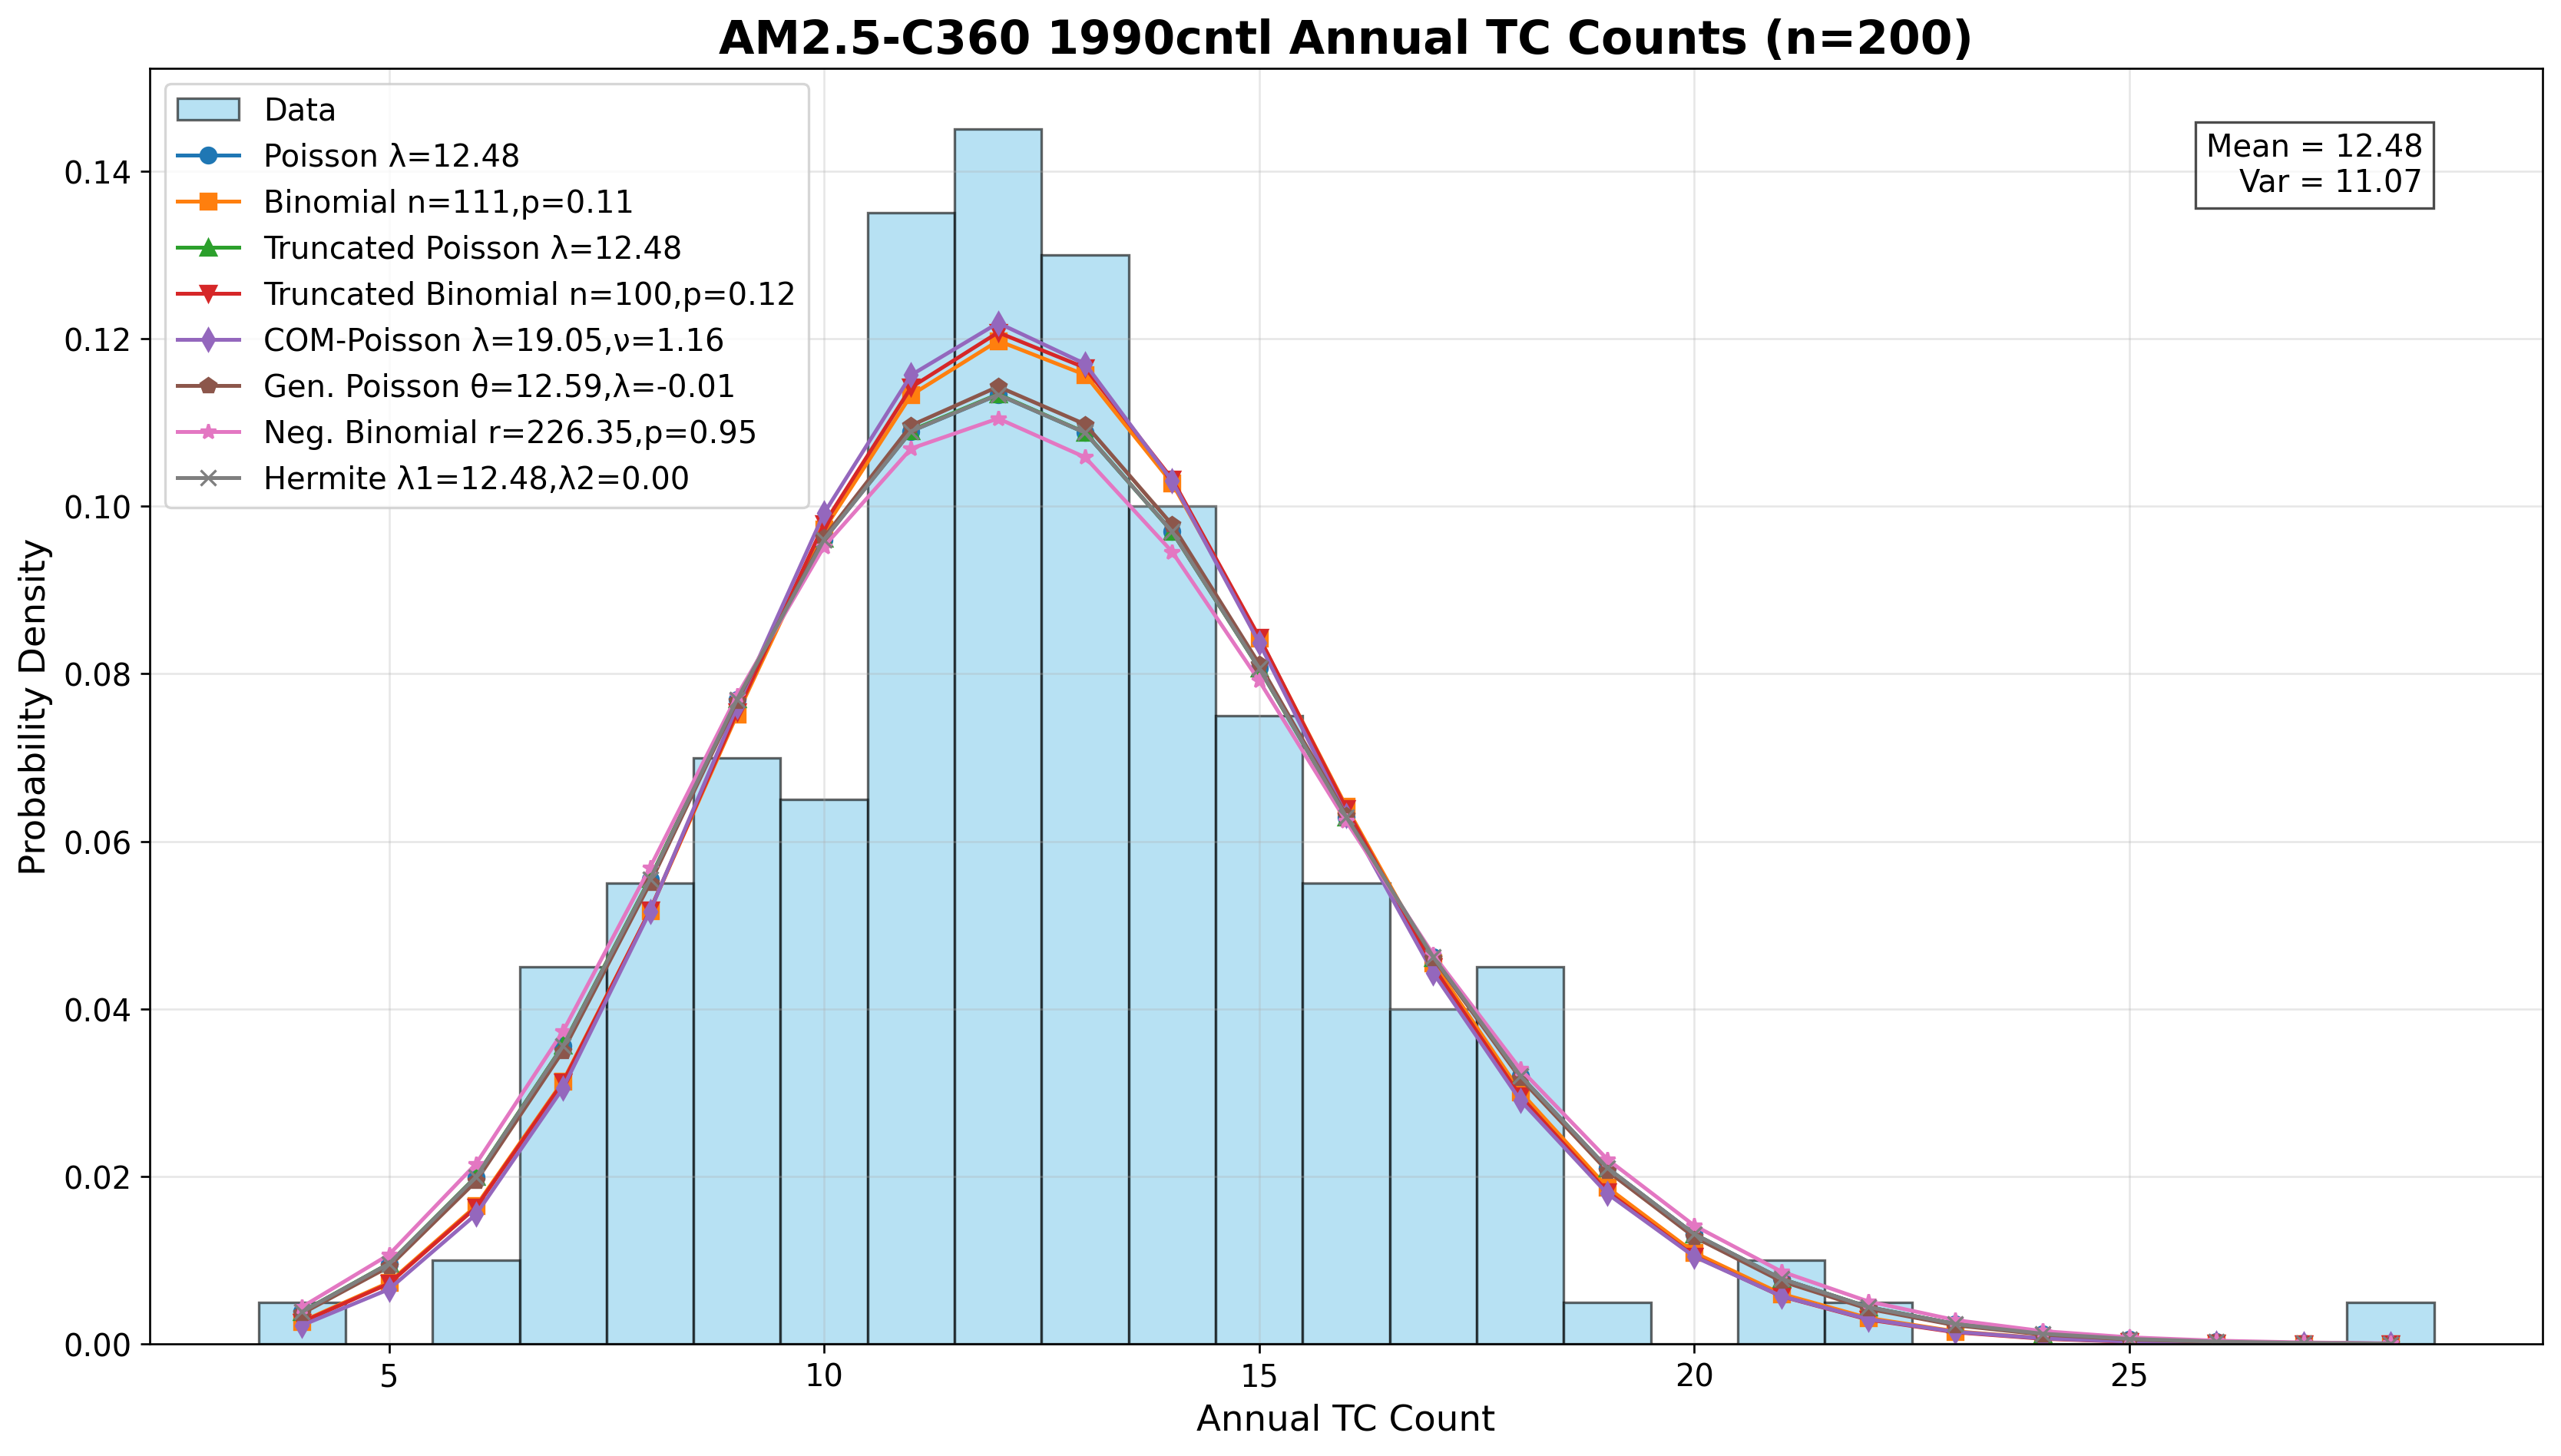


Chi-Square Goodness-of-Fit:
Poisson                  : χ² =   12.696, dof = 12, p-value = 0.3916
Binomial                 : χ² =   10.084, dof = 11, p-value = 0.5228
Truncated Poisson        : χ² =   12.685, dof = 12, p-value = 0.3923
Truncated Binomial       : χ² =    9.846, dof = 11, p-value = 0.5443
COM-Poisson              : χ² =    7.732, dof = 10, p-value = 0.6550
Generalized Poisson      : χ² =   12.178, dof = 11, p-value = 0.3504
Negative Binomial        : χ² =   14.470, dof = 11, p-value = 0.2081
Hermite                  : χ² =   12.696, dof = 11, p-value = 0.3137


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.special import factorial, gammaln
import warnings
warnings.filterwarnings('ignore')

# --- Use hiram xarray directly ---
data = hiram.values  # convert to numpy array
n_data = len(data)

# Basic statistics
data_mean = np.mean(data)
data_var = np.var(data, ddof=1)
print(f"Data mean: {data_mean:.3f}")
print(f"Data variance: {data_var:.3f}")
print(f"Dispersion ratio (var/mean): {data_var/data_mean:.3f}\n")

# --- Define k values for PMFs ---
k_vals = np.arange(int(data.min()), int(data.max())+1)

# -------------------
# 1. Poisson
# -------------------
lambda_mle = data_mean
poisson_pmf = stats.poisson.pmf(k_vals, lambda_mle)

# -------------------
# 2. Binomial (Method of Moments)
# -------------------
def fit_binomial(data):
    mean_data = np.mean(data)
    var_data = np.var(data, ddof=1)
    p_est = 1 - var_data / mean_data
    n_est = mean_data / p_est
    p_est = np.clip(p_est, 0.01, 0.99)
    n_est = max(int(np.ceil(n_est)), int(data.max())+1)
    return n_est, p_est

n_binom, p_binom = fit_binomial(data)
binomial_pmf = stats.binom.pmf(k_vals, n_binom, p_binom)

# -------------------
# 3. Truncated Poisson (left-truncated at data.min()-1)
# -------------------
lower_trunc = int(data.min()) - 1

def truncated_poisson_pmf(k, lam, lower=0):
    cdf_lower = stats.poisson.cdf(lower-1, lam) if lower>0 else 0
    pmf = stats.poisson.pmf(k, lam) / (1 - cdf_lower)
    pmf[k <= lower] = 0
    return pmf

def truncated_poisson_nll(lam, data, lower=0):
    if lam <= 0: return 1e10
    cdf_lower = stats.poisson.cdf(lower-1, lam) if lower>0 else 0
    ll = np.sum(stats.poisson.logpmf(data, lam)) - n_data*np.log(1-cdf_lower)
    return -ll

res_tpoisson = minimize(lambda x: truncated_poisson_nll(x[0], data, lower_trunc),
                        [data_mean], method='L-BFGS-B', bounds=[(0.1, 100)])
lambda_tpoisson = res_tpoisson.x[0]
tpoisson_pmf = truncated_poisson_pmf(k_vals, lambda_tpoisson, lower_trunc)

# -------------------
# 4. Truncated Binomial
# -------------------
def truncated_binomial_nll(params, data, lower=0):
    n, p = int(params[0]), params[1]
    if p<=0 or p>=1 or n<data.max(): return 1e10
    cdf_lower = stats.binom.cdf(lower-1, n, p) if lower>0 else 0
    ll = np.sum(stats.binom.logpmf(data, n, p)) - n_data*np.log(1-cdf_lower)
    return -ll

res_tbinom = minimize(lambda x: truncated_binomial_nll(x, data, lower_trunc),
                      [n_binom, p_binom], method='L-BFGS-B',
                      bounds=[(data.max()+1, 100), (0.01, 0.99)])
n_tbinom, p_tbinom = int(res_tbinom.x[0]), res_tbinom.x[1]
tbinom_pmf = stats.binom.pmf(k_vals, n_tbinom, p_tbinom)
tbinom_pmf[k_vals <= lower_trunc] = 0
tbinom_pmf /= 1 - stats.binom.cdf(lower_trunc, n_tbinom, p_tbinom)

# -------------------
# 5. COM-Poisson
# -------------------
def com_poisson_logZ(lam, nu, max_k=100):
    kvals = np.arange(max_k)
    log_terms = kvals*np.log(lam) - nu*gammaln(kvals+1)
    max_log = np.max(log_terms)
    return max_log + np.log(np.sum(np.exp(log_terms-max_log)))

def com_poisson_nll(params, data):
    lam, nu = params
    if lam<=0 or nu<=0: return 1e10
    logZ = com_poisson_logZ(lam, nu)
    ll = np.sum(data*np.log(lam) - nu*gammaln(data+1)) - n_data*logZ
    return -ll

res_comp = minimize(lambda x: com_poisson_nll(x, data),
                    [data_mean, 1.0], method='L-BFGS-B',
                    bounds=[(0.1,100),(0.1,10)])
lam_comp, nu_comp = res_comp.x
logZ_comp = com_poisson_logZ(lam_comp, nu_comp)
comp_pmf = np.exp(k_vals*np.log(lam_comp) - nu_comp*gammaln(k_vals+1) - logZ_comp)

# -------------------
# 6. Generalized Poisson
# -------------------
def gen_poisson_pmf(k, theta, lam):
    term1 = theta*(theta + lam*k)**(k-1)
    term2 = np.exp(-theta-lam*k)
    term3 = 1/factorial(k)
    return term1*term2*term3

theta_init = data_mean*(1-(data_var-data_mean)/data_mean**2)
lam_init = np.clip((data_var-data_mean)/data_mean**2, -0.9,0.9)

def gen_poisson_nll(params, data):
    theta, lam = params
    if theta<=0 or lam>=1 or lam<=-1: return 1e10
    try:
        ll = np.sum(np.log(theta) + (data-1)*np.log(theta + lam*data) - theta - lam*data - gammaln(data+1))
        return -ll
    except:
        return 1e10

res_gp = minimize(lambda x: gen_poisson_nll(x,data),
                  [theta_init, lam_init], method='L-BFGS-B',
                  bounds=[(0.1,100), (-0.99,0.99)])
theta_gp, lam_gp = res_gp.x
gp_pmf = gen_poisson_pmf(k_vals, theta_gp, lam_gp)

# -------------------
# 7. Negative Binomial
# -------------------
def nbinom_nll(params, data):
    r, p = params
    if r<=0 or p<=0 or p>=1: return 1e10
    return -np.sum(stats.nbinom.logpmf(data, r, p))

r_init = data_mean**2/(data_var-data_mean) if data_var>data_mean else 10
p_init = r_init/(r_init+data_mean)
res_nb = minimize(lambda x: nbinom_nll(x, data),
                  [r_init,p_init], method='L-BFGS-B',
                  bounds=[(1e-6,500),(1e-6,0.999999)])
r_nb, p_nb = res_nb.x
nb_pmf = stats.nbinom.pmf(k_vals, r_nb, p_nb)

# -------------------
# 8. Hermite
# -------------------
def hermite_pmf(k, lam1, lam2):
    pmf = np.zeros_like(k, dtype=float)
    for idx, ki in enumerate(k):
        m_vals = np.arange(0, ki//2 + 1)
        terms = (lam1**(ki-2*m_vals)/factorial(ki-2*m_vals))*(lam2**m_vals/factorial(m_vals))
        pmf[idx] = np.exp(-(lam1+lam2))*np.sum(terms)
    return pmf

def hermite_nll(params, data):
    lam1, lam2 = params
    if lam1<=0 or lam2<0: return 1e10
    pmf_vals = hermite_pmf(data, lam1, lam2)
    if np.any(pmf_vals<=0): return 1e10
    return -np.sum(np.log(pmf_vals))

res_herm = minimize(lambda x: hermite_nll(x, data),
                    [data_mean, max((data_mean**2-data_var)/2,0.1)],
                    method='L-BFGS-B', bounds=[(1e-6,200),(0,200)])
lam1_herm, lam2_herm = res_herm.x
herm_pmf = hermite_pmf(k_vals, lam1_herm, lam2_herm)

# -------------------
# Plot histogram + fitted distributions
# -------------------
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(data.min()-0.5, data.max()+1.5,1.0)

plt.figure(figsize=(14,8))

# Plot histogram
counts, _, _ = plt.hist(data, bins=bins, density=True, alpha=0.6, 
                        color='skyblue', edgecolor='black', label='Data')

# Plot fitted distributions
plt.plot(k_vals, poisson_pmf, 'o-', label=f'Poisson λ={lambda_mle:.2f}')
plt.plot(k_vals, binomial_pmf, 's-', label=f'Binomial n={n_binom},p={p_binom:.2f}')
plt.plot(k_vals, tpoisson_pmf, '^-', label=f'Truncated Poisson λ={lambda_tpoisson:.2f}')
plt.plot(k_vals, tbinom_pmf, 'v-', label=f'Truncated Binomial n={n_tbinom},p={p_tbinom:.2f}')
plt.plot(k_vals, comp_pmf, 'd-', label=f'COM-Poisson λ={lam_comp:.2f},ν={nu_comp:.2f}')
plt.plot(k_vals, gp_pmf, 'p-', label=f'Gen. Poisson θ={theta_gp:.2f},λ={lam_gp:.2f}')
plt.plot(k_vals, nb_pmf, '*-', label=f'Neg. Binomial r={r_nb:.2f},p={p_nb:.2f}')
plt.plot(k_vals, herm_pmf, 'x-', label=f'Hermite λ1={lam1_herm:.2f},λ2={lam2_herm:.2f}')

# Title with dataset size
plt.title(f'AM2.5-C360 1990cntl Annual TC Counts (n={len(data)})', fontsize=18, fontweight='bold')

# Axis labels
plt.xlabel('Annual TC Count', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)

# Tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend font size
plt.legend(fontsize=12)

# Grid
plt.grid(alpha=0.3)

# Text box for mean and variance
mean_val = np.mean(data)
var_val = np.var(data, ddof=1)
plt.text(0.95, 0.95, f'Mean = {mean_val:.2f}\nVar = {var_val:.2f}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.show()


# -------------------
# Chi-Square test
# -------------------
def chi_square_test_robust(name, observed_counts, expected_pmf, x_vals, min_expected=5):
    """
    Chi-square goodness-of-fit test with intelligent bin pooling.
    
    Parameters:
    -----------
    name : str
        Name of the distribution (for reporting)
    observed_counts : array-like
        Observed frequencies in each bin
    expected_pmf : array-like
        Expected probabilities for each value
    x_vals : array-like
        The x-values corresponding to each bin
    min_expected : float
        Minimum expected count per bin (default 5)
    
    Returns:
    --------
    chi2 : float or None
        Chi-square statistic
    dof : int or None
        Degrees of freedom
    p_value : float or None
        p-value for the test
    """
    n_data = np.sum(observed_counts)
    expected_counts = expected_pmf[x_vals - x_vals.min()] * n_data
    
    # Convert to lists for easier manipulation
    obs = list(observed_counts.copy())
    exp = list(expected_counts.copy())
    
    # Pool adjacent bins until all expected counts >= min_expected
    i = 0
    while i < len(exp):
        if exp[i] < min_expected:
            # Try to pool with next bin
            if i + 1 < len(exp):
                obs[i] += obs[i + 1]
                exp[i] += exp[i + 1]
                obs.pop(i + 1)
                exp.pop(i + 1)
                # Don't increment i, check this bin again
            # Try to pool with previous bin
            elif i > 0:
                obs[i - 1] += obs[i]
                exp[i - 1] += exp[i]
                obs.pop(i)
                exp.pop(i)
                i -= 1  # Go back to check the merged bin
            else:
                # Only one bin left and it's < min_expected
                return None, None, None
        else:
            i += 1
    
    # Need at least 3 bins for a meaningful test
    if len(exp) < 3:
        return None, None, None
    
    # Convert back to numpy arrays
    obs = np.array(obs)
    exp = np.array(exp)
    
    # Calculate chi-square statistic
    chi2 = np.sum((obs - exp)**2 / exp)
    
    # Parameter counts for DOF adjustment
    param_counts = {
        'Poisson': 1,
        'Binomial': 2,
        'Truncated Poisson': 1,
        'Truncated Binomial': 2,
        'COM-Poisson': 2,
        'Generalized Poisson': 2,
        'Negative Binomial': 2,
        'Hermite': 2,
    }
    
    n_params = param_counts.get(name, 2)  # Default to 2 if not found
    
    # Degrees of freedom
    dof = len(exp) - 1 - n_params
    
    if dof < 1:
        return None, None, None
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(chi2, dof)
    
    return chi2, dof, p_value

observed, _ = np.histogram(data, bins=bins)
distributions = {'Poisson':poisson_pmf,'Binomial':binomial_pmf,'Truncated Poisson':tpoisson_pmf,
                 'Truncated Binomial':tbinom_pmf,'COM-Poisson':comp_pmf,'Generalized Poisson':gp_pmf,
                 'Negative Binomial':nb_pmf,'Hermite':herm_pmf}

print("\nChi-Square Goodness-of-Fit:")
for name, pmf in distributions.items():
    chi2,dof,p_val = chi_square_test_robust(name, observed, pmf, k_vals)
    if chi2 is not None:
        print(f"{name:25s}: χ² = {chi2:8.3f}, dof = {dof:2d}, p-value = {p_val:.4f}")
    else:
        print(f"{name:25s}: Unable to compute (insufficient expected counts)")



GENERATING Q-Q PLOTS


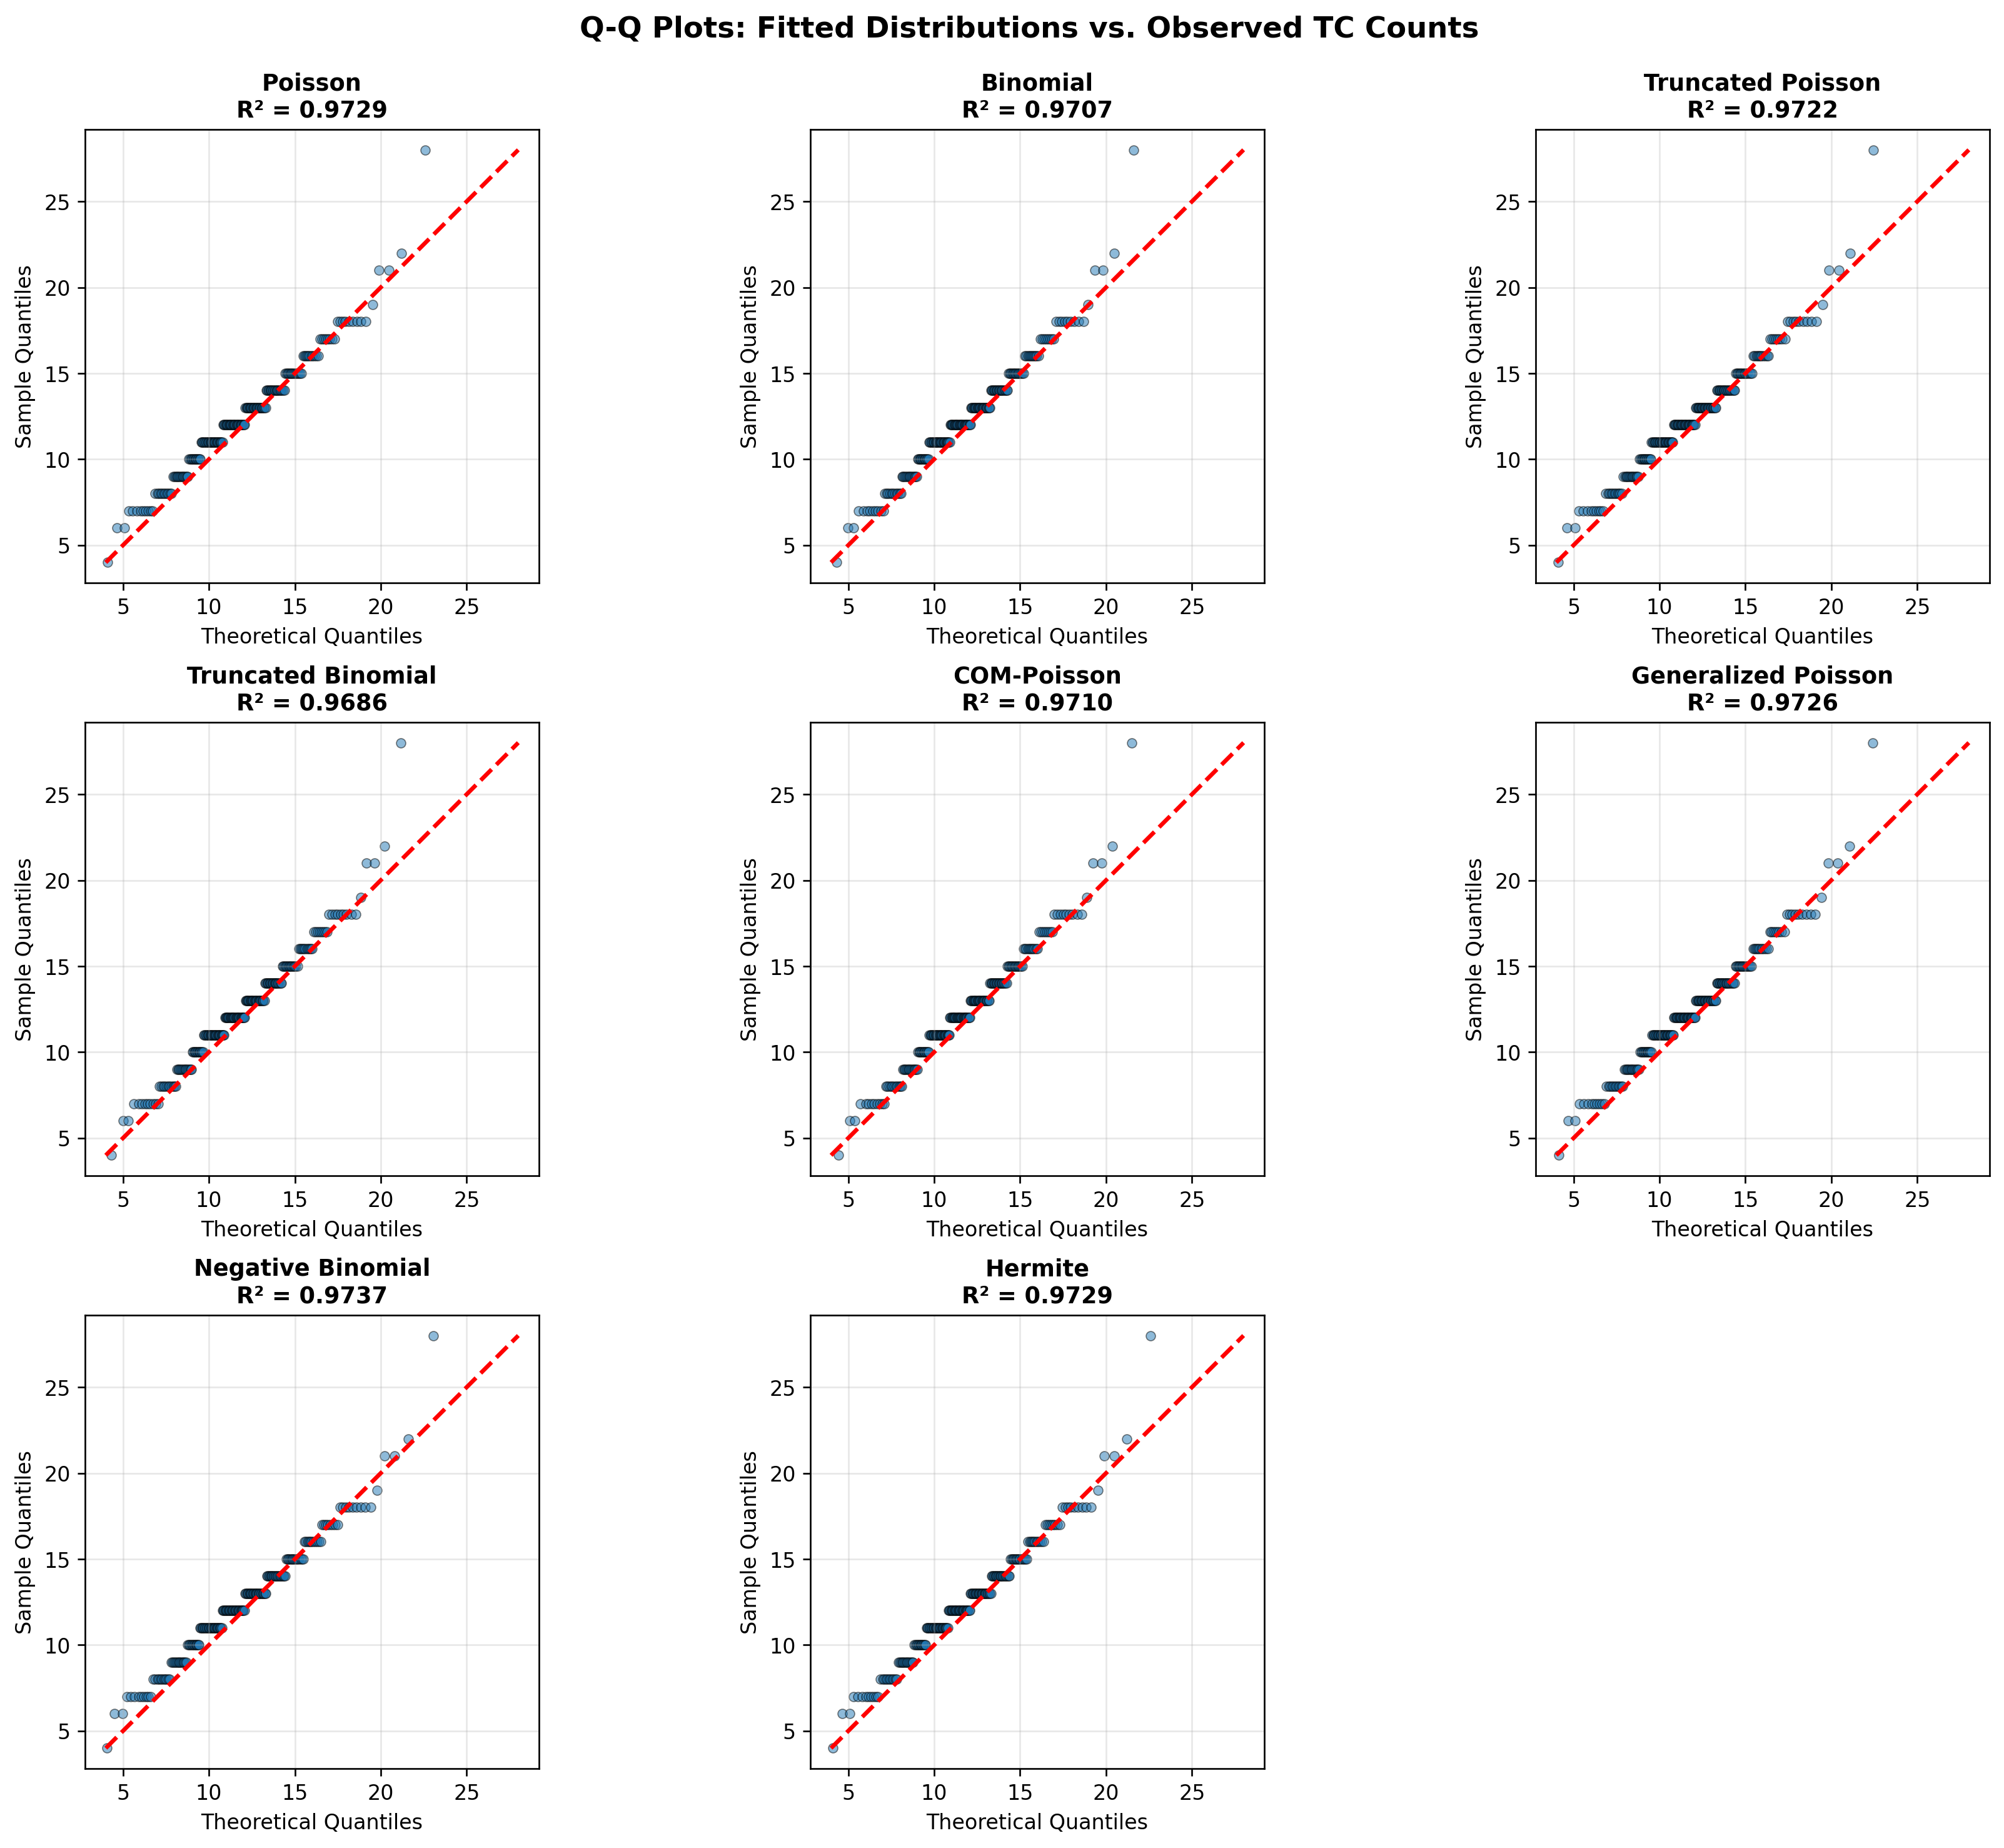


Q-Q Plot R² values (closer to 1 is better):
------------------------------------------------------------
Poisson                  : R² = 0.9729
Binomial                 : R² = 0.9707
Truncated Poisson        : R² = 0.9722
Truncated Binomial       : R² = 0.9686
COM-Poisson              : R² = 0.9710
Generalized Poisson      : R² = 0.9726
Negative Binomial        : R² = 0.9737
Hermite                  : R² = 0.9729


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------
# Q-Q PLOTS
# -------------------
print("\n" + "="*60)
print("GENERATING Q-Q PLOTS")
print("="*60)

def generate_theoretical_quantiles(pmf, x_vals, n_samples):
    """Generate theoretical quantiles from a PMF"""
    cdf = np.cumsum(pmf)
    quantiles = np.linspace(0, 1, n_samples + 2)[1:-1]
    theoretical = np.interp(quantiles, cdf, x_vals)
    return theoretical

# Sort observed data
data_sorted = np.sort(data)

# List of distributions and fitted parameters
distributions_list = [
    ('Poisson', poisson_pmf, f'λ={lambda_mle:.2f}'),
    ('Binomial', binomial_pmf, f'n={n_binom}, p={p_binom:.2f}'),
    ('Truncated Poisson', tpoisson_pmf, f'λ={lambda_tpoisson:.2f}'),
    ('Truncated Binomial', tbinom_pmf, f'n={n_tbinom}, p={p_tbinom:.2f}'),
    ('COM-Poisson', comp_pmf, f'λ={lam_comp:.2f}, ν={nu_comp:.2f}'),
    ('Generalized Poisson', gp_pmf, f'θ={theta_gp:.2f}, λ={lam_gp:.2f}'),
    ('Negative Binomial', nb_pmf, f'r={r_nb:.2f}, p={p_nb:.2f}'),
    ('Hermite', herm_pmf, f'λ1={lam1_herm:.2f}, λ2={lam2_herm:.2f}')
]

# 3x3 layout (extra subplot will be removed)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

x_vals = np.arange(int(data.min()), int(data.max())+1)

for idx, (name, pmf, params) in enumerate(distributions_list):
    ax = axes[idx]
    
    theoretical = generate_theoretical_quantiles(pmf, x_vals, len(data))
    
    ax.scatter(theoretical, data_sorted, alpha=0.5, s=20, edgecolors='black', linewidths=0.5)
    
    min_val = min(theoretical.min(), data_sorted.min())
    max_val = max(theoretical.max(), data_sorted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    correlation = np.corrcoef(theoretical, data_sorted)[0, 1]
    r_squared = correlation ** 2
    
    ax.set_title(f'{name}\nR² = {r_squared:.4f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.grid(alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Remove extra subplot if present
for j in range(len(distributions_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Q-Q Plots: Fitted Distributions vs. Observed TC Counts', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# -------------------
# Print R² table
# -------------------
print("\nQ-Q Plot R² values (closer to 1 is better):")
print("-" * 60)
for name, pmf, params in distributions_list:
    theoretical = generate_theoretical_quantiles(pmf, x_vals, len(data))
    r2 = np.corrcoef(theoretical, data_sorted)[0, 1] ** 2
    print(f"{name:25s}: R² = {r2:.4f}")
